In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
def chtoidx(ch):
    if ord(ch) >= ord('a') and ord(ch) <= ord('z'): 
        return ord(ch) - ord('a') + 1
    else: 
        return 0

def idxtoch(idx):
    if idx - 1 + ord('a') >= ord('a') and idx - 1 + ord('a') <= ord('z'):
        return chr(idx - 1 + ord('a'))
    else:
        return '.'

In [5]:
pair_counts = torch.ones((27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        pair_counts[chtoidx(ch1), chtoidx(ch2)] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

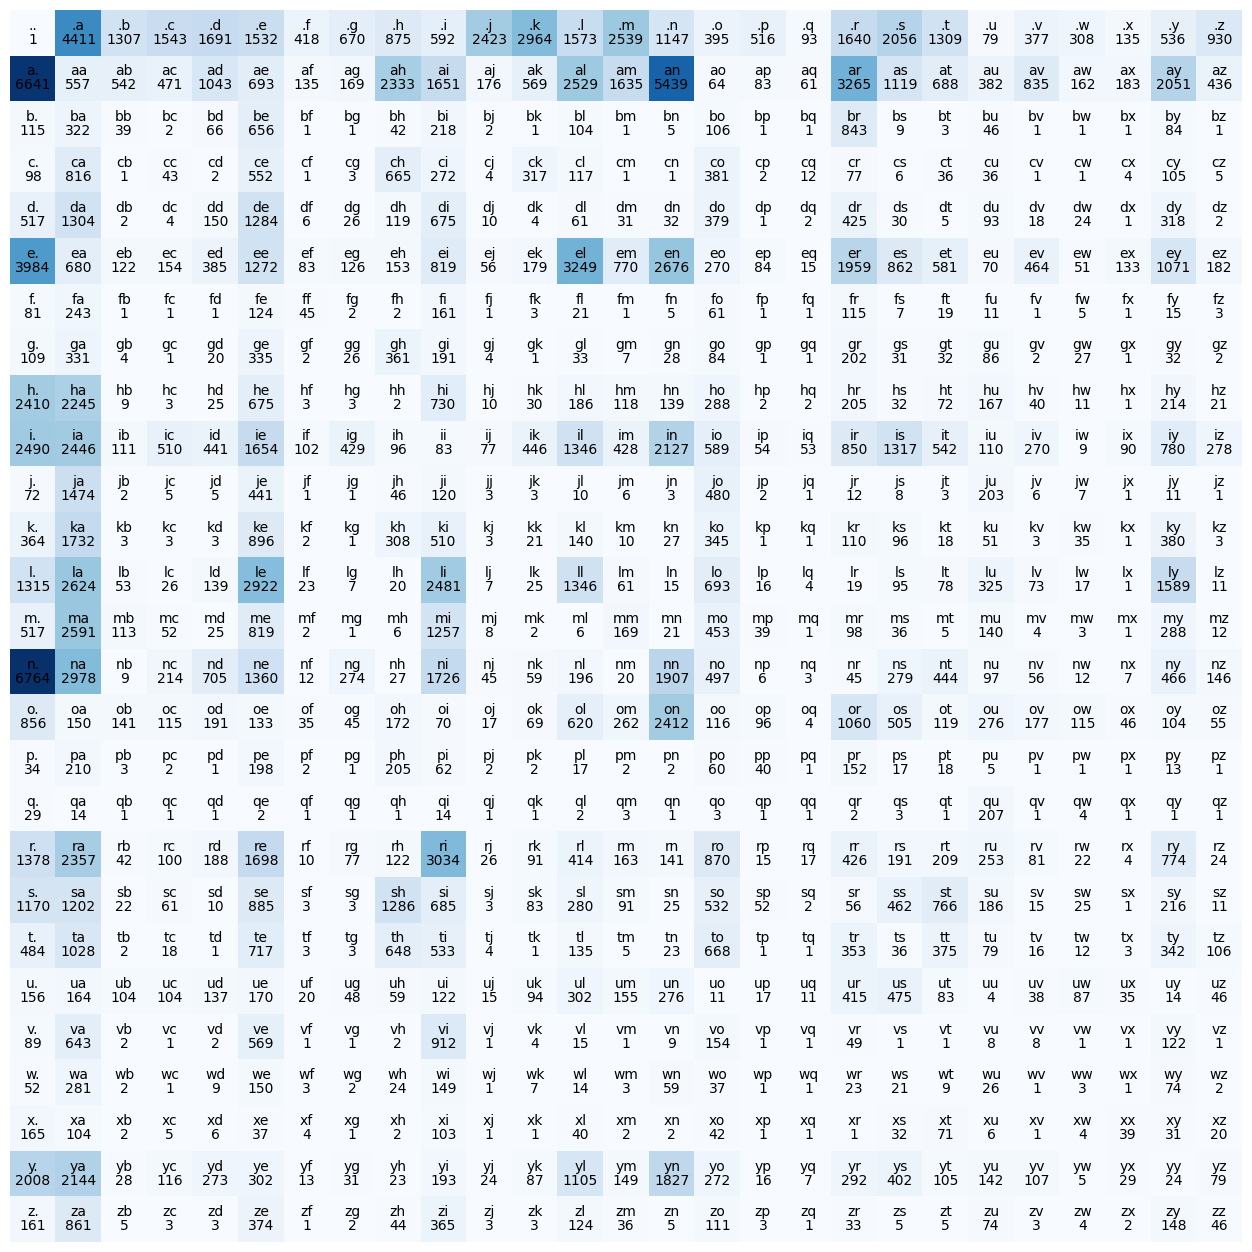

In [6]:
plt.figure(figsize=(16, 16))
plt.imshow(pair_counts, cmap='Blues')
for i in range(27):
    for j in range(27):
        plt.text(j, i, pair_counts[i, j].item(), ha='center', va='top', color='black')
        plt.text(j, i, idxtoch(i) + idxtoch(j), ha='center', va='bottom', color='black')
plt.axis('off')

In [7]:
## generate some names
probs = pair_counts.float() / pair_counts.sum(1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    idx = 0
    while True:
        p = probs[idx, :]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(idxtoch(idx))
        if idx == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [8]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        p = probs[chtoidx(ch1), chtoidx(ch2)]
        lp = torch.log(p)
        log_likelihood += lp
        n += 1
print(f'{-log_likelihood/n}')

2.4543561935424805


## Create dataset and NN

In [9]:
import torch.nn.functional as F

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(chtoidx(ch1))
        ys.append(chtoidx(ch2))

xs = torch.tensor(xs)
xenc = F.one_hot(xs, num_classes=27).float()
ys = torch.tensor(ys)

W = torch.randn((27,27), generator=g, requires_grad=True)


## Train

In [10]:
for i in range(500):
    logits = xenc @ W
    counts = logits.exp()
    counts_sum = counts.sum(1, keepdim=True)
    probs = counts / counts_sum

    nll = -probs[torch.arange(probs.shape[0]), ys].log().mean() + 0.01 * (W**2).mean()

    print(f'Loss: {nll}')
    
    W.grad = None
    nll.backward()

    W.data += W.grad * -70


Loss: 3.837569236755371
Loss: 3.3231492042541504
Loss: 3.081559181213379
Loss: 2.931442975997925
Loss: 2.829643726348877
Loss: 2.760289430618286
Loss: 2.712459087371826
Loss: 2.6783335208892822
Loss: 2.6528420448303223
Loss: 2.632938861846924
Loss: 2.6168525218963623
Loss: 2.6035146713256836
Loss: 2.5922470092773438
Loss: 2.5825955867767334
Loss: 2.5742437839508057
Loss: 2.56695818901062
Loss: 2.5605623722076416
Loss: 2.5549163818359375
Loss: 2.5499067306518555
Loss: 2.545440435409546
Loss: 2.541440010070801
Loss: 2.5378406047821045
Loss: 2.534588098526001
Loss: 2.5316364765167236
Loss: 2.5289456844329834
Loss: 2.526484489440918
Loss: 2.5242247581481934
Loss: 2.522141933441162
Loss: 2.520216464996338
Loss: 2.51842999458313
Loss: 2.51676869392395
Loss: 2.515219211578369
Loss: 2.5137710571289062
Loss: 2.51241397857666
Loss: 2.5111396312713623
Loss: 2.5099406242370605
Loss: 2.5088107585906982
Loss: 2.5077438354492188
Loss: 2.506734848022461
Loss: 2.505779981613159
Loss: 2.5048747062683105

/tmp/ipykernel_19836/522453560.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gen_logits = F.one_hot(torch.arange(27), num_classes=27).float() @ W.detach().numpy()


(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

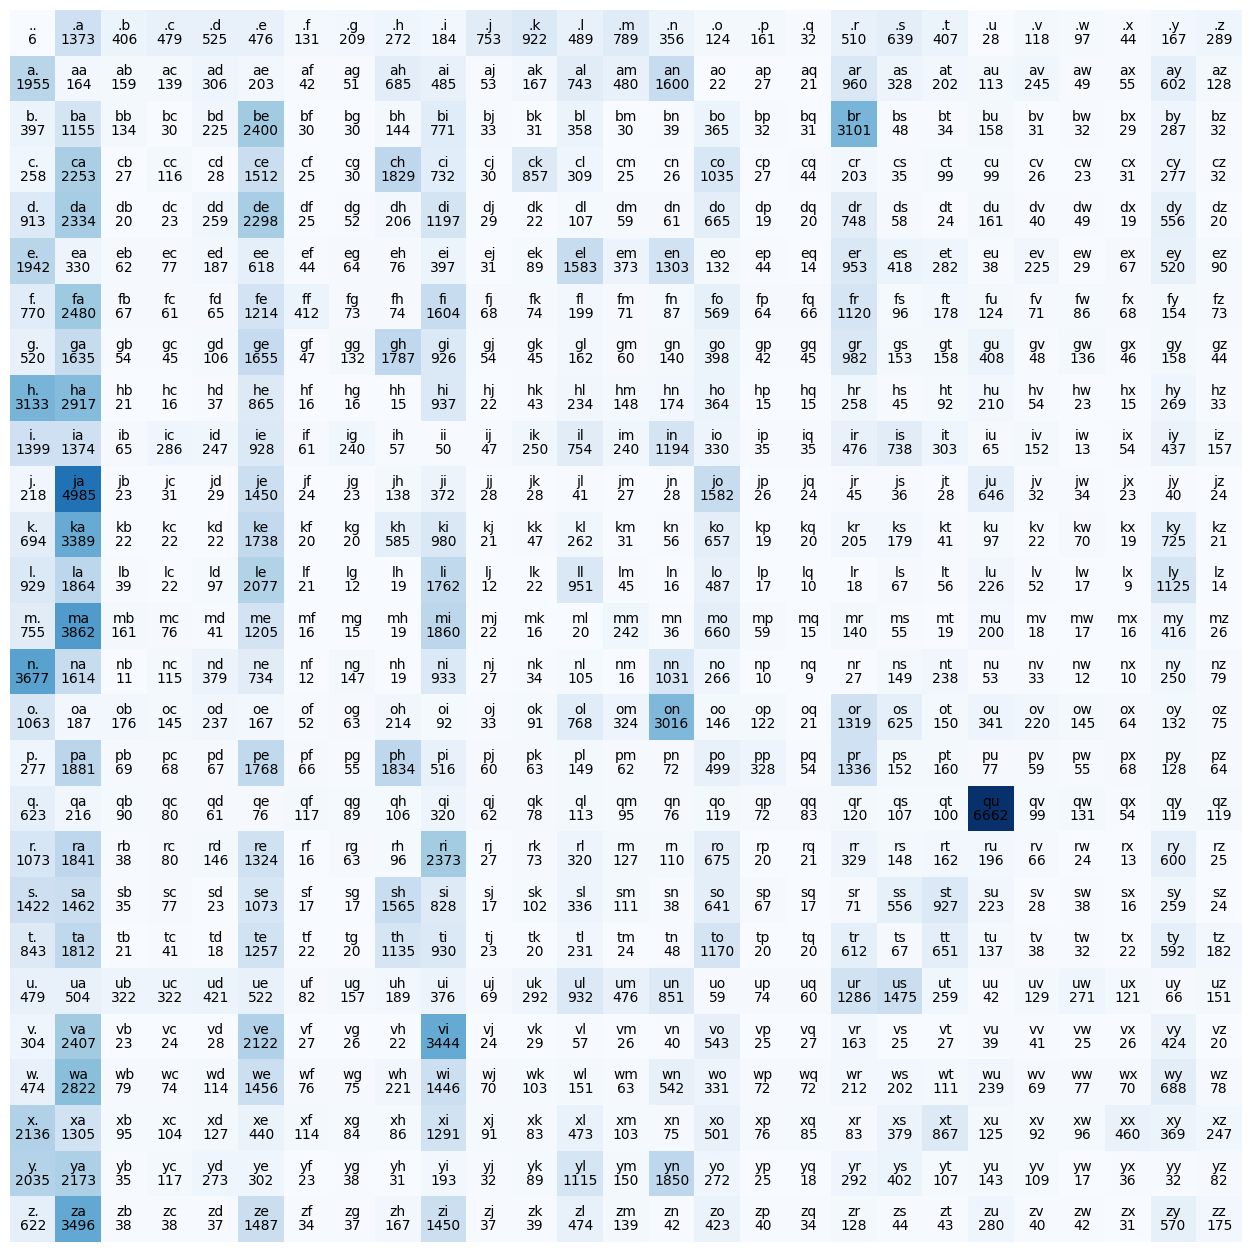

In [11]:
gen_logits = F.one_hot(torch.arange(27), num_classes=27).float() @ W.detach().numpy()
gen_counts = gen_logits.exp()
gen_counts_sum = gen_counts.sum(1, keepdim=True)
gen_probs = gen_counts / gen_counts_sum
gen_probs = (gen_probs * 10000).int()

plt.figure(figsize=(16, 16))
plt.imshow(gen_probs, cmap='Blues')
for i in range(27):
    for j in range(27):
        plt.text(j, i, gen_probs[i, j].item(), ha='center', va='top', color='black')
        plt.text(j, i, idxtoch(i) + idxtoch(j), ha='center', va='bottom', color='black')
plt.axis('off')

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

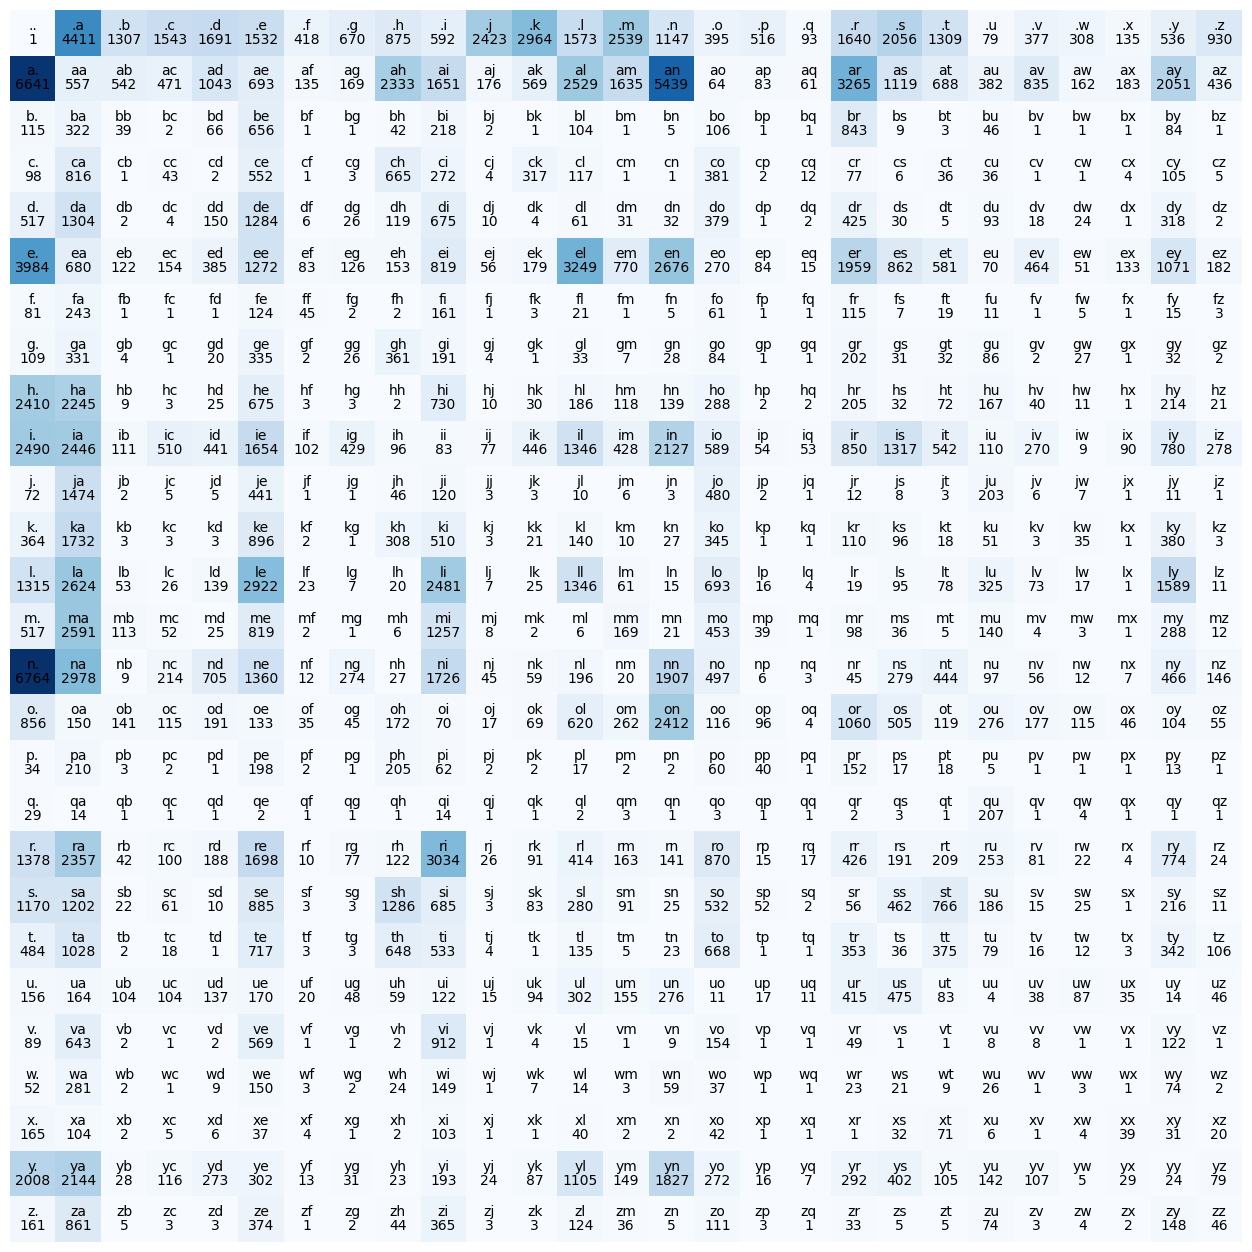

In [543]:
plt.figure(figsize=(16, 16))
plt.imshow(pair_counts, cmap='Blues')
for i in range(27):
    for j in range(27):
        plt.text(j, i, pair_counts[i, j].item(), ha='center', va='top', color='black')
        plt.text(j, i, idxtoch(i) + idxtoch(j), ha='center', va='bottom', color='black')
plt.axis('off')

In [12]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    idx = 0
    while True:
        logits = F.one_hot(torch.tensor([idx]), 27).float() @ W
        counts = logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        probs = counts / counts_sum

        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(idxtoch(idx))
        if idx == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cfay.
a.
nn.
kohin.
tolian.
juwe.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
